# Symmetry WTA

## Intro

* **Date**: 12/5/2020
* **What**: This is essentially a Krotov Hopfield winner-takes-all network, but I'm reducing the dimensionality of the input to 9 components, which should encode some aspect of the spatial symmetry that is inherent to handwritten digits.
* **Why**: The grand failure of DreamFlow showed me that my networks need to have some notion of symmetry, in the sense that inputs that are "close" to being the same in terms of their spatial orientation should register as the same input.
* **Hopes**: My hope is that this gets a better wta classification accuracy than Krotov and Hopfield's architecture.
* **Limitations**: I don't think I'm using enough dimensions.  I don't exactly know how to put this into words, but this architecture has some limitations, in that different inputs in the input space map to the same 9-dimensional representation, but I don't think that should matter because most of the digits aren't symmetrical.  I guess the network might have some trouble with eights and zeros.  Hmm.  You know what, I can just map it to 16-dimensions and save myself the trouble.  So yeah, 16 dimensions now.

## Code

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

side_len = 28
L = side_len ** 2
S = 60000

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x / 255.0, test_x / 255.0

flat_x = train_x.reshape(train_x.shape[0], -1)
flat_test = test_x.reshape(test_x.shape[0], -1)

In [33]:
def draw_weights(w, Kx, Ky, fig):
    tapestry = np.zeros((28 * Ky, 28 * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * 28: (y + 1) * 28, x * 28: (x + 1) * 28] = w[w_i].reshape(28, 28)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Reds", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

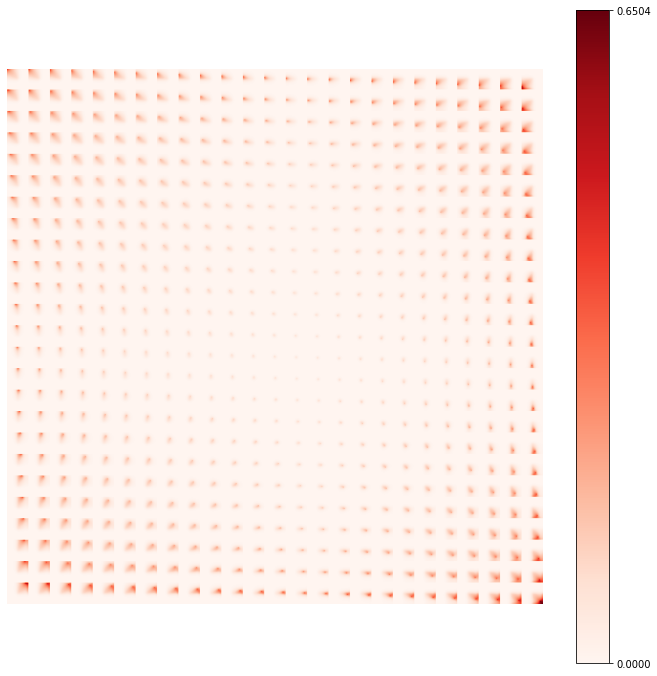

In [61]:
sptl_filters = []

fl_side_len = 25
fl_len = fl_side_len ** 2

for i in range(fl_side_len):
    for j in range(fl_side_len):
        y, x = np.mgrid[0:side_len, 0:side_len]
        
        y = y - (j * (side_len // (fl_side_len - 1)))
        x = x - (i * (side_len // (fl_side_len - 1)))
        
        min_dist = -np.sqrt((x ** 2) + (y ** 2))
        
        min_dist += -np.min(min_dist)
        
        sptl_filters.append(min_dist.reshape(-1) ** 10)
        
fl = np.array(sptl_filters)

fl /= np.linalg.norm(fl, axis=0)
        
fig = plt.figure(figsize=(12, 12))

draw_weights(fl, fl_side_len, fl_side_len, fig)

I'm a big fan of that for some reason.  Also I'm pretty sure this is gonna fail but whatever.  Here's the code for the boi.

In [62]:
def wta_classification(w, fl):
    v = flat_x[:T_s]
    train_lbls = train_y[:T_s]
    
    wins = np.argmax(w[:, :L] @ (flat_x[:T_s, :] @ fl.T).T, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / np.array([np.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_mul_v = w[:, :L] @ (test_v[i] @ fl.T).T
        
        n_max = np.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)

In [63]:
w_max = 1
Kx = 10
Ky = 10
xi = 0.001

N = Kx * Ky

Nep = 10
B = 100

T_s = 60000

w = np.abs(np.random.uniform(0, 1, (N, fl_len)))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B] @ fl.T
        
        o = w @ v.T
        
        wins = np.argmax(o, axis=0)
        
        win_mask = np.zeros((N, B))
        win_mask[wins, np.arange(B)] = 1
        win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (np.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
        w = np.clip(w, 0, 1)
    
wta_classification(w, fl)

100%|██████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 351.19it/s]


Neuron classes: [1 4 9 2 0 8 2 4 8 1 3 8 8 7 3 6 8 6 9 6 8 5 6 2 1 3 1 8 2 3 0 7 2 1 7 1 7
 4 3 7 0 2 3 0 6 2 9 4 7 9 4 1 5 0 9 6 9 3 4 6 0 9 3 7 7 3 0 6 9 2 7 7 8 2
 5 0 6 0 5 2 0 4 6 7 2 5 1 0 5 3 9 9 2 4 6 8 5 4 1 5]
Accuracy: 76.36%
Misclassifieds:  [113.  18. 199. 302. 328. 440. 114. 196. 387. 267.]


## Analysis Dialog

Well, it doesn't work.  I'm guessing the inputs are simply less crisp, and there's presumably a lot of muddiness.  Feel free to mess around with any of the parameters like `fl_len` or `Kx` and `Ky`.  You know what?  Feel free to do whatever the fuck you want. 

## Conclusions

It didn't work.  Muddiness I suppose.  Mess around with it all you want, if you want.

## Next Steps

Take a long hard look at my life and try to figure out what the fuck I'm doing.  
